In [ ]:
Team 10

In [1]:
#loading the important libraries for Exploratory Data Ananlysis.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install mlxtend
!pip install scikit-learn-extra
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids


C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


In [2]:
#reading the dataset
brain = pd.read_csv("data/brain_stroke.csv")
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
#shape of the data
brain.shape

(4981, 11)

In [4]:
#checking for NA values in the dataset
brain.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [ ]:
#checking basic info about the data-set
brain.info() 

In [ ]:
# Now, we will try to convert the categorical data into binary data which will help us in visualizing on the data well and it will computationally less expensive for us when we try to train our models on this dataset.

In [ ]:
brain["gender"].unique() #checking the unique values in the column "gender"
# Here, Male can be mapped to 1 and Female can be mapped to 0.

In [ ]:
brain["gender"] = brain["gender"].map({"Male":1, "Female":0})

In [181]:
#Similarly, we will check for other columns!

In [182]:
brain["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children'], dtype=object)

In [183]:
brain["Residence_type"].unique()

array(['Urban', 'Rural'], dtype=object)

In [184]:
# Convert them as Urban = 1 and Rural as 0
brain["Residence_type"] = brain["Residence_type"].map({"Urban":1, "Rural":0})

In [185]:
brain["ever_married"].unique()

array(['Yes', 'No'], dtype=object)

In [186]:
# Yes can be mapped to 1 and no can be mapped to 0.
brain["ever_married"] = brain["ever_married"].map({"Yes":1, "No":0})

In [187]:
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1


In [188]:
brain["smoking_status"].unique()
#We have identified that the "smoking_status" column has four unique values, including "Unknown." It is prudent to exclude rows with unknown smoking status from our model training since predicting outcomes for individuals without smoking status information lacks meaningful input. Additionally, retaining such unknown values might introduce noise and compromise the model's predictive accuracy, emphasizing the importance of removing these instances.As Four unique values are present, we can't change it to Binary values. Thus we will leave it as it is.

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [189]:
# #counting the number of Unknowns in the "smoke_staus"
unknown_count = brain['smoking_status'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' in smoking_status: {unknown_count}")

Number of 'Unknown' in smoking_status: 1500


In [190]:
# We will now remove these 1500 rows!
brain = brain[brain['smoking_status'] != 'Unknown']

# Resetting the index
brain.reset_index(drop=True, inplace=True)
brain["smoking_status"].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

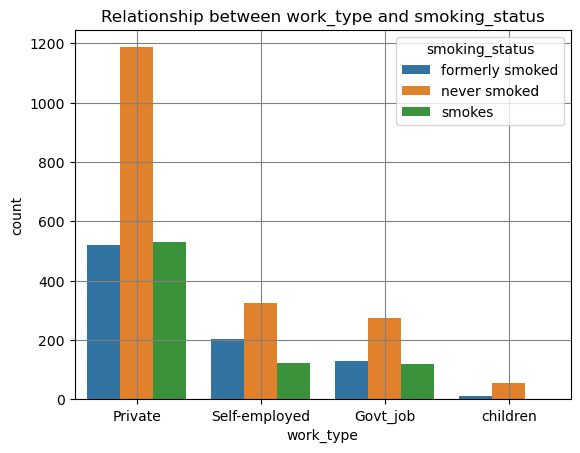

In [191]:
plt.figure()
sns.countplot(x='work_type', hue='smoking_status', data=brain)
plt.title('Relationship between work_type and smoking_status')
plt.grid(color = "gray")
plt.show()

In [192]:
# The bar chart depicts the correlation between 'work_type' and 'smoking_status'. It features four bars (private, self-employed, government, and children), each divided into three sections (smokes, formerly smoked, and never smoked). The y-axis represents the count of individuals, while the x-axis represents work types. Notably, individuals in the private sector are more likely to smoke, with approximately 500 people, and have almost equal incidence of past smoking compared to other sectors. Self-employed and government workers show lower smoking counts and a proportionally smaller "formerly smoked" segment. Children exhibit the least smoking prevalence.

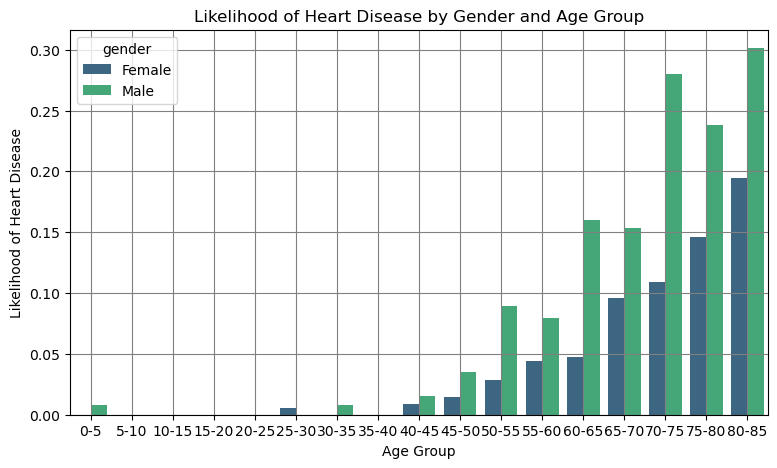

In [5]:
bins = range(0, int(brain['age'].max()) + 6, 5)
labels = [f'{start}-{end}' for start, end in zip(bins[:-1], bins[1:])]
brain['age_group'] = pd.cut(brain['age'], bins=bins, labels=labels, right=False)

# Grouping by 'gender' and 'age_group' and calculating the mean of 'heart_disease'
grouped_data = brain.groupby(['gender', 'age_group'])['heart_disease'].mean().reset_index()

# Creating a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='age_group', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [6]:
# The graph shows that the likelihood of heart disease increases with age for both males and females, but it is higher for males than for females at all ages. The likelihood of heart disease is also highest for males in the 70-75 age group and for females in the 80-85 age group.

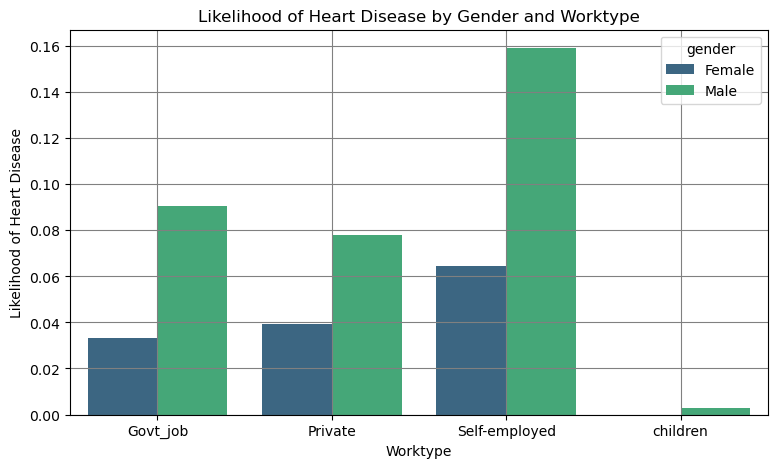

In [7]:
grouped_data = brain.groupby(['gender', 'work_type'])['heart_disease'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='work_type', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Worktype')
plt.xlabel('Worktype')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [8]:
# The graph shows that the likelihood of heart disease is higher for people who are self-employed than for people who work in government jobs or private sector jobs. The likelihood of heart disease is also higher for males than for females in all work types.

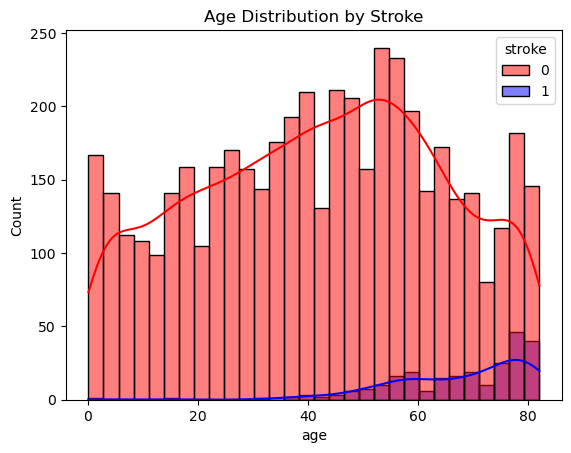

In [9]:
plt.figure()
sns.histplot(x='age', hue='stroke', data=brain, kde=True, bins=30, palette=['red', 'blue'])
plt.title('Age Distribution by Stroke')

plt.show()

In [10]:
# The plot shows that the age distribution of stroke patients is skewed to the right, meaning that there are more older stroke patients than younger stroke patients. The median age of stroke patients in the dataset is 65 years old. Patients with a history of stroke are also more likely to be older than patients without a history of stroke.

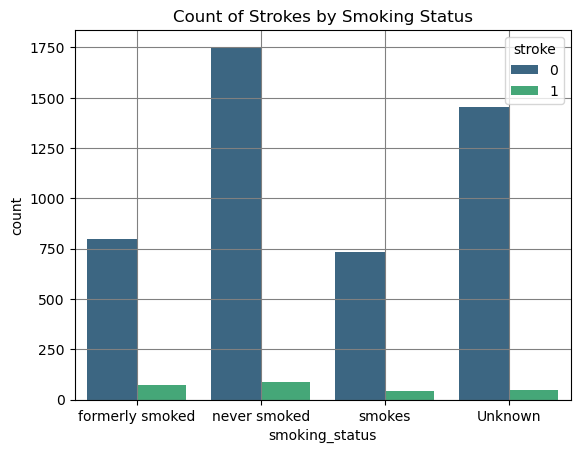

In [11]:
sns.countplot(x='smoking_status', hue='stroke', data=brain, palette='viridis')
plt.title('Count of Strokes by Smoking Status')
plt.grid(color = "gray")
plt.show()

In [12]:
# It's unexpected to observe that the likelihood of experiencing a stroke is not much influenced by an individual's smoking status. Despite this, it can be deduced that individuals who have never smoked exhibit a lower susceptibility to stroke.

C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


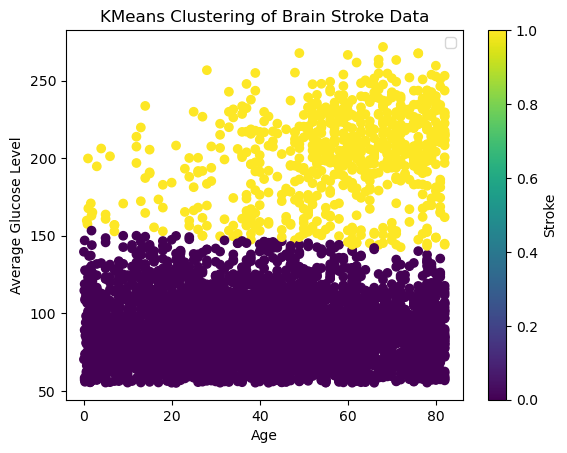

In [13]:
# Performing K-mean Clustering

# file_path = 'data/brain_stroke.csv'

# # Read the CSV file
# data = pd.read_csv(file_path)

data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Scale numerical values
# scaler = StandardScaler()
# numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Focus on stroke column for clustering
X = data.drop('stroke', axis=1)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust the number of clusters
data['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.scatter(data['age'], data['avg_glucose_level'], c=data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMeans Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=["Cluster 0", "Cluster 1", "Cluster 2"])  # Add labels for clusters
plt.show()


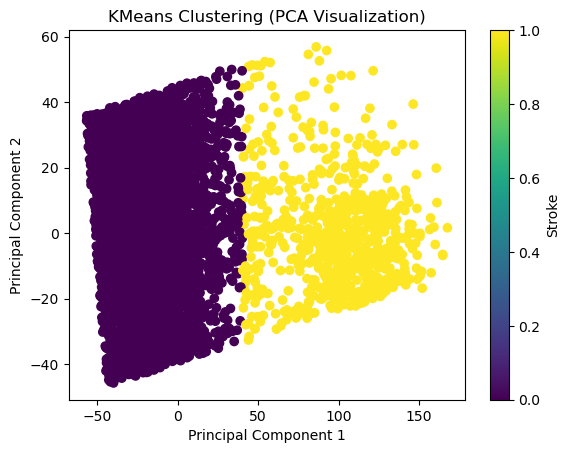

In [14]:
# Use PCA to reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Visualize clusters in 2D
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=data['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (PCA Visualization)')

# Create legend handles and labels
# legend_labels = [f'Cluster {i}' for i in range(len(set(data["cluster"])))]
# plt.legend(handles=plt.scatter.legend_elements()[0], labels=legend_labels)

plt.colorbar(label='Stroke')
plt.show()

In [15]:
# Performance Evaluation

# Evaluating the performance of k-means clustering using Inertia, Silhouette Score and Davies-Bouldin Index metrics
# Fit KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)
# the result is quite high, which might indicate that the clusters are not tightly grouped.

# Silhouette Score
silhouette = silhouette_score(X, data['cluster'])
print("Silhouette Score:", silhouette)
#  A higher silhouette score indicates better-defined clusters. Since the silhoutte score is 0.645, which is is reasonable,
#  it indicates there are well-separated clusters.

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, data['cluster'])
print("Davies-Bouldin Index:", davies_bouldin)
# A lower score suggests better separation between clusters. Since thescore is 0.515, it indicates good cluster distinctiveness.


# Overall, even though the inertia is relatively high, the Silhouette Score and Davies-Bouldin Index suggest decent 
# clustering performance with well-defined and distinct clusters in the data.

C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia: 4884873.630149752
Silhouette Score: 0.645302574132893
Davies-Bouldin Index: 0.5154841272072542


In [16]:
# Association Rule Mining

# Copying the dataset to new variable to perform apriori

brain_stroke_copy = brain.copy()
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,80-85
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,45-50
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,75-80
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,80-85


In [17]:
# Mapping numerical values of 'hypertension' column to categorical labels
brain_stroke_copy['hypertension'] =brain_stroke_copy['hypertension'].map({0: 'No Hypertension', 1: 'Hypertension'})
# brain['hypertension'] = brain['hypertension'].astype('category')


In [18]:
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.0,No Hypertension,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Male,80.0,No Hypertension,1,Yes,Private,Rural,105.92,32.5,never smoked,1,80-85
2,Female,49.0,No Hypertension,0,Yes,Private,Urban,171.23,34.4,smokes,1,45-50
3,Female,79.0,Hypertension,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,75-80
4,Male,81.0,No Hypertension,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,80-85


In [19]:
brain_stroke_copy['heart_disease'].fillna(0, inplace=True)
brain_stroke_copy['heart_disease'] = brain_stroke_copy['heart_disease'].map({0: 'No Heart Disease', 1: 'Heart Disease'})
# brain['heart_disease'] = brain['heart_disease'].astype('category')

In [20]:
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.0,No Hypertension,Heart Disease,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Male,80.0,No Hypertension,Heart Disease,Yes,Private,Rural,105.92,32.5,never smoked,1,80-85
2,Female,49.0,No Hypertension,No Heart Disease,Yes,Private,Urban,171.23,34.4,smokes,1,45-50
3,Female,79.0,Hypertension,No Heart Disease,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,75-80
4,Male,81.0,No Hypertension,No Heart Disease,Yes,Private,Urban,186.21,29.0,formerly smoked,1,80-85


In [21]:
# Select columns for association
association_data = brain_stroke_copy[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying Apriori Algorithm
frequent_itemsets = apriori(association_data_encoded, min_support=0.1, use_colnames=True)

# Generating association rules for the given data
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print(rules)


                                          antecedents  \
0                    (heart_disease_No Heart Disease)   
1                      (hypertension_No Hypertension)   
2                            (smoking_status_Unknown)   
3                    (smoking_status_formerly smoked)   
4                       (smoking_status_never smoked)   
5                             (smoking_status_smokes)   
6                            (smoking_status_Unknown)   
7                    (smoking_status_formerly smoked)   
8                       (smoking_status_never smoked)   
9                             (smoking_status_smokes)   
10  (heart_disease_No Heart Disease, smoking_statu...   
11  (hypertension_No Hypertension, smoking_status_...   
12                           (smoking_status_Unknown)   
13  (heart_disease_No Heart Disease, smoking_statu...   
14  (hypertension_No Hypertension, smoking_status_...   
15                   (smoking_status_formerly smoked)   
16  (heart_disease_No Heart Dis

In [22]:
# Performance Evaluation

#Performing metrics-based evaluation on the association rules generated by the Apriori algorithm
# Assessing Support
min_support_threshold = 0.1
high_support_rules = rules[rules['support'] > min_support_threshold]
high_support_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.944790,0.903835,0.861474,0.911815,1.008829,0.007540,1.090493,0.158521
1,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.903835,0.944790,0.861474,0.953132,1.008829,0.007540,1.177983,0.091009
2,(smoking_status_Unknown),(hypertension_No Hypertension),0.301144,0.903835,0.291106,0.966667,1.069517,0.018922,2.884963,0.093007
3,(smoking_status_formerly smoked),(hypertension_No Hypertension),0.174061,0.903835,0.150974,0.867359,0.959643,-0.006349,0.725004,-0.048450
4,(smoking_status_never smoked),(hypertension_No Hypertension),0.369002,0.903835,0.324232,0.878672,0.972161,-0.009285,0.792610,-0.043413
5,(smoking_status_smokes),(hypertension_No Hypertension),0.155792,0.903835,0.137523,0.882732,0.976652,-0.003288,0.820048,-0.027538
6,(smoking_status_Unknown),(heart_disease_No Heart Disease),0.301144,0.944790,0.291508,0.968000,1.024566,0.006989,1.725306,0.034309
7,(smoking_status_formerly smoked),(heart_disease_No Heart Disease),0.174061,0.944790,0.158603,0.911188,0.964434,-0.005849,0.621648,-0.042741
8,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.369002,0.944790,0.351134,0.951578,1.007184,0.002505,1.140175,0.011304
9,(smoking_status_smokes),(heart_disease_No Heart Disease),0.155792,0.944790,0.143545,0.921392,0.975234,-0.003645,0.702341,-0.029203


In [23]:
# Evaluating Confidence
min_confidence_threshold = 0.7
high_confidence_rules = rules[rules['confidence'] > min_confidence_threshold]
high_confidence_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.944790,0.903835,0.861474,0.911815,1.008829,0.007540,1.090493,0.158521
1,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.903835,0.944790,0.861474,0.953132,1.008829,0.007540,1.177983,0.091009
2,(smoking_status_Unknown),(hypertension_No Hypertension),0.301144,0.903835,0.291106,0.966667,1.069517,0.018922,2.884963,0.093007
3,(smoking_status_formerly smoked),(hypertension_No Hypertension),0.174061,0.903835,0.150974,0.867359,0.959643,-0.006349,0.725004,-0.048450
4,(smoking_status_never smoked),(hypertension_No Hypertension),0.369002,0.903835,0.324232,0.878672,0.972161,-0.009285,0.792610,-0.043413
5,(smoking_status_smokes),(hypertension_No Hypertension),0.155792,0.903835,0.137523,0.882732,0.976652,-0.003288,0.820048,-0.027538
6,(smoking_status_Unknown),(heart_disease_No Heart Disease),0.301144,0.944790,0.291508,0.968000,1.024566,0.006989,1.725306,0.034309
7,(smoking_status_formerly smoked),(heart_disease_No Heart Disease),0.174061,0.944790,0.158603,0.911188,0.964434,-0.005849,0.621648,-0.042741
8,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.369002,0.944790,0.351134,0.951578,1.007184,0.002505,1.140175,0.011304
9,(smoking_status_smokes),(heart_disease_No Heart Disease),0.155792,0.944790,0.143545,0.921392,0.975234,-0.003645,0.702341,-0.029203


In [24]:
# Analyzing Lift
min_lift_threshold = 1.0 
high_lift_rules = rules[rules['lift'] > min_lift_threshold]
high_lift_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.944790,0.903835,0.861474,0.911815,1.008829,0.007540,1.090493,0.158521
1,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.903835,0.944790,0.861474,0.953132,1.008829,0.007540,1.177983,0.091009
2,(smoking_status_Unknown),(hypertension_No Hypertension),0.301144,0.903835,0.291106,0.966667,1.069517,0.018922,2.884963,0.093007
6,(smoking_status_Unknown),(heart_disease_No Heart Disease),0.301144,0.944790,0.291508,0.968000,1.024566,0.006989,1.725306,0.034309
8,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.369002,0.944790,0.351134,0.951578,1.007184,0.002505,1.140175,0.011304
10,"(heart_disease_No Heart Disease, smoking_statu...",(hypertension_No Hypertension),0.291508,0.903835,0.282473,0.969008,1.072108,0.018999,3.102938,0.094931
11,"(hypertension_No Hypertension, smoking_status_...",(heart_disease_No Heart Disease),0.291106,0.944790,0.282473,0.970345,1.027048,0.007439,1.861726,0.037150
12,(smoking_status_Unknown),"(heart_disease_No Heart Disease, hypertension_...",0.301144,0.861474,0.282473,0.938000,1.088832,0.023045,2.234297,0.116740
17,"(hypertension_No Hypertension, smoking_status_...",(heart_disease_No Heart Disease),0.324232,0.944790,0.310982,0.959133,1.015181,0.004650,1.350967,0.022129


In [25]:
# Generating frequent itemsets using FP-Growth algorithm 

# Selecting required columns for FP-Growth
association_data = brain_stroke_copy[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying FP-Growth algorithm
frequent_itemsets = fpgrowth(association_data_encoded, min_support=0.1, use_colnames=True)

# Print the result
print(frequent_itemsets)

     support                                           itemsets
0   0.903835                     (hypertension_No Hypertension)
1   0.174061                   (smoking_status_formerly smoked)
2   0.369002                      (smoking_status_never smoked)
3   0.944790                   (heart_disease_No Heart Disease)
4   0.155792                            (smoking_status_smokes)
5   0.301144                           (smoking_status_Unknown)
6   0.861474  (heart_disease_No Heart Disease, hypertension_...
7   0.150974  (hypertension_No Hypertension, smoking_status_...
8   0.158603  (heart_disease_No Heart Disease, smoking_statu...
9   0.139731  (heart_disease_No Heart Disease, hypertension_...
10  0.324232  (hypertension_No Hypertension, smoking_status_...
11  0.351134  (heart_disease_No Heart Disease, smoking_statu...
12  0.310982  (heart_disease_No Heart Disease, hypertension_...
13  0.143545  (heart_disease_No Heart Disease, smoking_statu...
14  0.137523  (hypertension_No Hypertens

In [26]:
# Performance Evaluation

# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Evaluate the generated association rules using support, confidence, and lift metrics:
print("Support:")
print(rules[['support']])
print("=" * 40)

print("Confidence:")
print(rules[['confidence']])
print("=" * 40)
# Since the confidence values are high it suggest strong associations between the antecedent and consequent

print("Lift:")
print(rules[['lift']])
print("=" * 40)
# Lift greater than 1 indicates a significant association between antecedent and consequent.

Support:
     support
0   0.861474
1   0.861474
2   0.150974
3   0.158603
4   0.139731
5   0.139731
6   0.139731
7   0.324232
8   0.351134
9   0.310982
10  0.310982
11  0.310982
12  0.143545
13  0.137523
14  0.128287
15  0.128287
16  0.128287
17  0.291508
18  0.291106
19  0.282473
20  0.282473
21  0.282473
Confidence:
    confidence
0     0.911815
1     0.953132
2     0.867359
3     0.911188
4     0.881013
5     0.925532
6     0.802768
7     0.878672
8     0.951578
9     0.885649
10    0.959133
11    0.842764
12    0.921392
13    0.882732
14    0.893706
15    0.932847
16    0.823454
17    0.968000
18    0.966667
19    0.969008
20    0.970345
21    0.938000
Lift:
        lift
0   1.008829
1   1.008829
2   0.959643
3   0.964434
4   0.974750
5   0.979616
6   0.931855
7   0.972161
8   1.007184
9   0.979879
10  1.015181
11  0.978282
12  0.975234
13  0.976652
14  0.988794
15  0.987359
16  0.955866
17  1.024566
18  1.069517
19  1.072108
20  1.027048
21  1.088832


# Clustering

C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


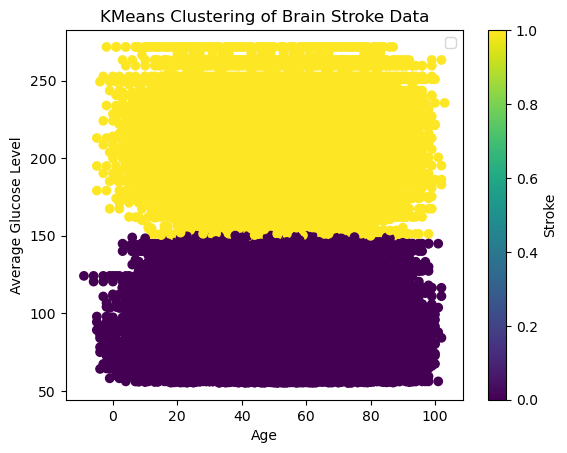

In [8]:
#K-means Clustering

file_path = 'data/stroke_data.csv'

# Read the CSV file
data = pd.read_csv(file_path)

data = pd.get_dummies(data, columns=['sex', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Scale numerical values
# scaler = StandardScaler()
# numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Focus on stroke column for clustering
X = data.drop('stroke', axis=1)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust the number of clusters
data['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.scatter(data['age'], data['avg_glucose_level'], c=data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMeans Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=["Cluster 0", "Cluster 1"]) 
plt.show()


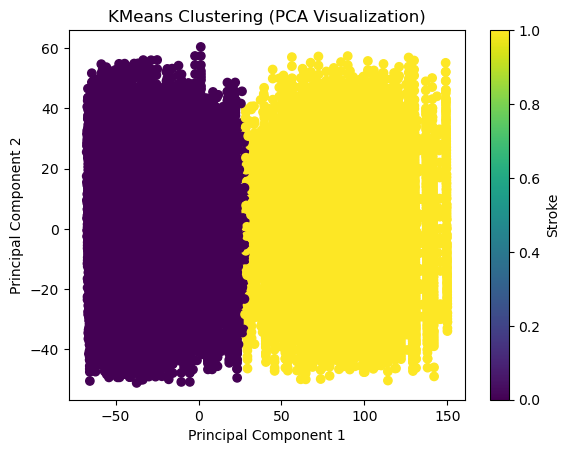

In [9]:
# Use PCA to reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Visualize clusters in 2D
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=data['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (PCA Visualization)')

# Create legend handles and labels
# legend_labels = [f'Cluster {i}' for i in range(len(set(data["cluster"])))]
# plt.legend(handles=plt.scatter.legend_elements()[0], labels=legend_labels)

plt.colorbar(label='Stroke')
plt.show()

In [10]:
# Performance Evaluation

# Evaluating the performance of k-means clustering using Inertia, Silhouette Score and Davies-Bouldin Index metrics
# Fit KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)
# the result is quite high, which might indicate that the clusters are not tightly grouped.

# Silhouette Score
silhouette = silhouette_score(X, data['cluster'])
print("Silhouette Score:", silhouette)
#  A higher silhouette score indicates better-defined clusters. Since the silhoutte score is 0.645, which is is reasonable,
#  it indicates there are well-separated clusters.

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, data['cluster'])
print("Davies-Bouldin Index:", davies_bouldin)
# A lower score suggests better separation between clusters. Since thescore is 0.515, it indicates good cluster distinctiveness.


# Overall, even though the inertia is relatively high, the Silhouette Score and Davies-Bouldin Index suggest decent 
# clustering performance with well-defined and distinct clusters in the data.

C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia: 41080678.54702708
Silhouette Score: 0.6602728269212786
Davies-Bouldin Index: 0.5000763715690575


In [11]:
len(data)

40910

In [28]:
sampled_data = data.sample(frac=0.5, random_state=42)
sampled_data.describe()
len(sampled_data)

2490

In [30]:
#K-medoids clustering

X = sampled_data.drop('stroke', axis=1)

# Perform KMedoids clustering
n_clusters = 2  # Specify the number of clusters
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
sampled_data['cluster'] = kmedoids.fit_predict(X)

# Visualizing clusters
plt.scatter(sampled_data['age'], sampled_data['avg_glucose_level'], c=sampled_data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMedoids Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=[f"Cluster {i}" for i in range(n_clusters)]) 
plt.show()

ValueError: Length of values (2490) does not match length of index (4981)

# Association

In [11]:
# Association Rule Mining

stroke_data = pd.read_csv("data/stroke_data.csv")
stroke_data.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [12]:
# Mapping numerical values of 'hypertension' column to categorical labels
stroke_data['hypertension'] =stroke_data['hypertension'].map({0: 'No Hypertension', 1: 'Hypertension'})
# brain['hypertension'] = brain['hypertension'].astype('category')

In [13]:
# Mapping numerical values of 'heart_disease' column to categorical labels
stroke_data['heart_disease'].fillna(0, inplace=True)
stroke_data['heart_disease'] = stroke_data['heart_disease'].map({0: 'No Heart Disease', 1: 'Heart Disease'})
# brain['heart_disease'] = brain['heart_disease'].astype('category')

In [14]:
# Mapping numerical values of 'smoking_status' column to categorical labels
stroke_data['smoking_status'].fillna(0, inplace=True)
stroke_data['smoking_status'] = stroke_data['smoking_status'].map({1: 'smokes', 0: 'never smoked'})

In [15]:
stroke_data.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,No Hypertension,Heart Disease,1,4,1,228.69,36.6,smokes,1
1,1.0,42.0,No Hypertension,Heart Disease,1,4,0,105.92,32.5,never smoked,1
2,0.0,61.0,No Hypertension,No Heart Disease,1,4,1,171.23,34.4,smokes,1
3,1.0,41.0,Hypertension,No Heart Disease,1,3,0,174.12,24.0,never smoked,1
4,1.0,85.0,No Hypertension,No Heart Disease,1,4,1,186.21,29.0,smokes,1


### Apriori

In [16]:
# Select columns for association
association_data = stroke_data[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying Apriori Algorithm
frequent_itemsets_apriori = apriori(association_data_encoded, min_support=0.1, use_colnames=True)

# Generating association rules for the given data
rules = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.7)
print(rules)

                                          antecedents  \
0                         (hypertension_Hypertension)   
1                    (heart_disease_No Heart Disease)   
2                      (hypertension_No Hypertension)   
3                       (smoking_status_never smoked)   
4                             (smoking_status_smokes)   
5                       (smoking_status_never smoked)   
6                             (smoking_status_smokes)   
7   (hypertension_Hypertension, smoking_status_nev...   
8   (heart_disease_No Heart Disease, smoking_statu...   
9   (hypertension_No Hypertension, smoking_status_...   
10                      (smoking_status_never smoked)   
11  (heart_disease_No Heart Disease, smoking_statu...   
12  (smoking_status_smokes, hypertension_No Hypert...   

                                          consequents  antecedent support  \
0                    (heart_disease_No Heart Disease)            0.213835   
1                      (hypertension_No Hyperte

In [17]:
frequent_itemsets_apriori

,support,itemsets
0,0.213835,(hypertension_Hypertension)
1,0.786165,(hypertension_No Hypertension)
2,0.127719,(heart_disease_Heart Disease)
3,0.872281,(heart_disease_No Heart Disease)
4,0.511391,(smoking_status_never smoked)
5,0.488609,(smoking_status_smokes)
6,0.175581,"(heart_disease_No Heart Disease, hypertension_..."
7,0.113004,"(hypertension_Hypertension, smoking_status_nev..."
8,0.100831,"(smoking_status_smokes, hypertension_Hypertens..."
9,0.696700,"(heart_disease_No Heart Disease, hypertension_..."


In [18]:
# Performance Evaluation

#Performing metrics-based evaluation on the association rules generated by the Apriori algorithm
# Assessing Support
min_support_threshold = 0.1
high_support_rules = rules[rules['support'] > min_support_threshold]
high_support_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(hypertension_Hypertension),(heart_disease_No Heart Disease),0.213835,0.872281,0.175581,0.821102,0.941328,-0.010944,0.713923,-0.073459
1,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.872281,0.786165,0.696700,0.798711,1.015959,0.010944,1.062329,0.122989
2,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.786165,0.872281,0.696700,0.886201,1.015959,0.010944,1.122325,0.073459
3,(smoking_status_never smoked),(hypertension_No Hypertension),0.511391,0.786165,0.398387,0.779026,0.990919,-0.003651,0.967694,-0.018410
4,(smoking_status_smokes),(hypertension_No Hypertension),0.488609,0.786165,0.387778,0.793637,1.009504,0.003651,1.036207,0.018410
5,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.511391,0.872281,0.468981,0.917069,1.051346,0.022904,1.540068,0.099954
6,(smoking_status_smokes),(heart_disease_No Heart Disease),0.488609,0.872281,0.403300,0.825404,0.946260,-0.022904,0.731514,-0.099954
7,"(hypertension_Hypertension, smoking_status_nev...",(heart_disease_No Heart Disease),0.113004,0.872281,0.102200,0.904391,1.036812,0.003629,1.335852,0.040028
8,"(heart_disease_No Heart Disease, smoking_statu...",(hypertension_No Hypertension),0.468981,0.786165,0.366781,0.782081,0.994805,-0.001915,0.981259,-0.009738
9,"(hypertension_No Hypertension, smoking_status_...",(heart_disease_No Heart Disease),0.398387,0.872281,0.366781,0.920665,1.055469,0.019276,1.609877,0.087355


In [19]:
# Evaluating Confidence
min_confidence_threshold = 0.7
high_confidence_rules = rules[rules['confidence'] > min_confidence_threshold]
high_confidence_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(hypertension_Hypertension),(heart_disease_No Heart Disease),0.213835,0.872281,0.175581,0.821102,0.941328,-0.010944,0.713923,-0.073459
1,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.872281,0.786165,0.696700,0.798711,1.015959,0.010944,1.062329,0.122989
2,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.786165,0.872281,0.696700,0.886201,1.015959,0.010944,1.122325,0.073459
3,(smoking_status_never smoked),(hypertension_No Hypertension),0.511391,0.786165,0.398387,0.779026,0.990919,-0.003651,0.967694,-0.018410
4,(smoking_status_smokes),(hypertension_No Hypertension),0.488609,0.786165,0.387778,0.793637,1.009504,0.003651,1.036207,0.018410
5,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.511391,0.872281,0.468981,0.917069,1.051346,0.022904,1.540068,0.099954
6,(smoking_status_smokes),(heart_disease_No Heart Disease),0.488609,0.872281,0.403300,0.825404,0.946260,-0.022904,0.731514,-0.099954
7,"(hypertension_Hypertension, smoking_status_nev...",(heart_disease_No Heart Disease),0.113004,0.872281,0.102200,0.904391,1.036812,0.003629,1.335852,0.040028
8,"(heart_disease_No Heart Disease, smoking_statu...",(hypertension_No Hypertension),0.468981,0.786165,0.366781,0.782081,0.994805,-0.001915,0.981259,-0.009738
9,"(hypertension_No Hypertension, smoking_status_...",(heart_disease_No Heart Disease),0.398387,0.872281,0.366781,0.920665,1.055469,0.019276,1.609877,0.087355


In [20]:
# Analyzing Lift
min_lift_threshold = 1.0 
high_lift_rules = rules[rules['lift'] > min_lift_threshold]
high_lift_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,(heart_disease_No Heart Disease),(hypertension_No Hypertension),0.872281,0.786165,0.696700,0.798711,1.015959,0.010944,1.062329,0.122989
2,(hypertension_No Hypertension),(heart_disease_No Heart Disease),0.786165,0.872281,0.696700,0.886201,1.015959,0.010944,1.122325,0.073459
4,(smoking_status_smokes),(hypertension_No Hypertension),0.488609,0.786165,0.387778,0.793637,1.009504,0.003651,1.036207,0.018410
5,(smoking_status_never smoked),(heart_disease_No Heart Disease),0.511391,0.872281,0.468981,0.917069,1.051346,0.022904,1.540068,0.099954
7,"(hypertension_Hypertension, smoking_status_nev...",(heart_disease_No Heart Disease),0.113004,0.872281,0.102200,0.904391,1.036812,0.003629,1.335852,0.040028
9,"(hypertension_No Hypertension, smoking_status_...",(heart_disease_No Heart Disease),0.398387,0.872281,0.366781,0.920665,1.055469,0.019276,1.609877,0.087355
10,(smoking_status_never smoked),"(heart_disease_No Heart Disease, hypertension_...",0.511391,0.696700,0.366781,0.717222,1.029456,0.010495,1.072572,0.058560
11,"(heart_disease_No Heart Disease, smoking_statu...",(hypertension_No Hypertension),0.403300,0.786165,0.329919,0.818050,1.040557,0.012859,1.175239,0.065320


In [34]:
# Generating frequent itemsets using FP-Growth algorithm 

# Selecting required columns for FP-Growth
association_data = stroke_data[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying FP-Growth algorithm
frequent_itemsets_fpgrowth = fpgrowth(association_data_encoded, min_support=0.1, use_colnames=True)

# Print the result
print(frequent_itemsets)

     support                                           itemsets
0   0.213835                        (hypertension_Hypertension)
1   0.786165                     (hypertension_No Hypertension)
2   1.000000                   (heart_disease_No Heart Disease)
3   1.000000                      (smoking_status_never smoked)
4   0.213835  (heart_disease_No Heart Disease, hypertension_...
5   0.213835  (smoking_status_never smoked, hypertension_Hyp...
6   0.786165  (hypertension_No Hypertension, heart_disease_N...
7   0.786165  (smoking_status_never smoked, hypertension_No ...
8   1.000000  (smoking_status_never smoked, heart_disease_No...
9   0.213835  (smoking_status_never smoked, heart_disease_No...
10  0.786165  (smoking_status_never smoked, hypertension_No ...


In [36]:
# Performance Evaluation

# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Evaluate the generated association rules using support, confidence, and lift metrics:
print("Support:")
print(rules[['support']])
print("=" * 40)

print("Confidence:")
print(rules[['confidence']])
print("=" * 40)
# Since the confidence values are high it suggest strong associations between the antecedent and consequent

print("Lift:")
print(rules[['lift']])
print("=" * 40)
# Lift values of 1.0 suggest that there's no significant association between the antecedent and consequent.

# Overall, high confidence levels and a lift of 1.0 may suggest that, despite the great degree of confidence in the rules,
# there is not much of a dependency between the antecedents and consequents because the lift barely varies from 1.0.

Support:
     support
0   0.213835
1   0.213835
2   0.786165
3   0.786165
4   0.786165
5   0.786165
6   1.000000
7   1.000000
8   0.213835
9   0.213835
10  0.213835
11  0.786165
12  0.786165
13  0.786165
14  0.786165
15  0.786165
16  0.786165
Confidence:
    confidence
0     1.000000
1     1.000000
2     1.000000
3     0.786165
4     0.786165
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    0.786165
13    1.000000
14    0.786165
15    1.000000
16    0.786165
Lift:
    lift
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
10   1.0
11   1.0
12   1.0
13   1.0
14   1.0
15   1.0
16   1.0
